#  **Trabalho A2 - Introdução à Ciência de Dados com Python**

---



## Introdução

Esse trabalho consiste em analisar a situação do Terceiro Setor por meio das Organizações da Sociedade Civil (OSC). As OSCs dependem de financiamento público e de doações de terceiros, uma vez que são caracterizadas como sem fins lucrativos. Elas possuem o papel fundamental de atuar com viés social nos setores nos quais o Estado não possui a capacidade gerencial necessária para atender a demanda existente.

Objetivamos com base nos conhecimentos adquiridos em aula, a montagem de mapas, ferramentas de visualização e regressão linear e gráficos que sejam capazes de responder as perguntas que formularemos.

**Observação:** 

Os dados de recursos são referentes ao ano de 2010 e posterior (até 2022). Já os dados de criação, áreas e subareas de atuação das OSC, não possuem restrições de data.

**Fonte:**

Os dados utilizados foram extraídos do Mapa das OSCs do Ipea (https://mapaosc.ipea.gov.br/base-dados).


## Importando bibliotecas

In [ ]:
!pip install geobr
!pip install geopandas

In [ ]:
pip install mapclassify

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import geopandas as gpd
import geobr
import plotly.express as px
import json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tratando os dados

Abaixo, lemos os arquivos CSV extraídos do Mapa do Ipea e criamos um dataframe com os dados geométricos da biblioteca geobr.

In [5]:
df1 = pd.read_csv ('/content/drive/MyDrive/Trabalho Python/recursos.csv',on_bad_lines='skip',sep=';')

In [6]:
df2 = pd.read_csv('/content/drive/MyDrive/Trabalho Python/area_subarea.csv',on_bad_lines='skip',sep=';')

In [7]:
df_map = geobr.read_municipality()

/usr/local/lib/python3.7/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [8]:
df_map2 = geobr.read_state()

In [9]:
df_map.rename(columns = {'name_muni':'edmu_nm_municipio','code_muni':'edmu_cd_municipio'}, inplace = True)

In [10]:
df_map2.rename(columns = {'abbrev_state':'eduf_sg_uf'}, inplace = True)

Transformamos objects em datetime.

In [11]:
df1['dt_ano_recursos_osc'] = pd.to_datetime(df1['dt_ano_recursos_osc'])

In [12]:
df2['dt_fundacao_osc'] = pd.to_datetime(df2['dt_fundacao_osc'])

**Dataframes:**


* **df1:** informações referente a declaração de cada OSC sobre seus recursos, a partir de 2010

* **df2:** informações relacionadas a cada OSC

* **df_map:** dados geométricos por município

* **df_map2:** dados geométricos por UF


## Perguntas e Análises

O objetivo dessa seção é explorar os dados.

### **Análise do número de OSCs por UF, município, ano e atividade econômica.**

#### 1. Número de OSCs criadas por UF e município

In [13]:
df_mn = df2.groupby(by='edmu_cd_municipio')['id_osc'].count().reset_index(name='num_osc')
df_mn = df_mn.sort_values(by = 'num_osc',ascending = False)

In [14]:
df_uf = df2.groupby(by='eduf_sg_uf')['id_osc'].count().reset_index(name='num_osc')
df_uf = df_uf.sort_values(by = 'num_osc',ascending = False)

In [15]:
df3 = pd.merge(df_mn, df_map, how = 'left', on = 'edmu_cd_municipio')
df4 = pd.merge(df_uf, df_map2, how = 'left', on = 'eduf_sg_uf')

In [16]:
df3 = gpd.GeoDataFrame(df3[['edmu_cd_municipio','num_osc','geometry']], geometry='geometry')
df4 = gpd.GeoDataFrame(df4[['eduf_sg_uf','num_osc','geometry']], geometry='geometry')

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array in

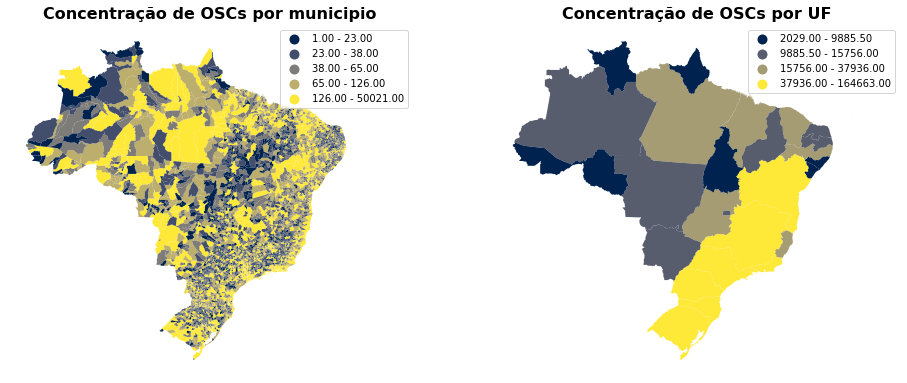

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

ax1 = df3.plot(ax=ax1, column='num_osc', legend=True, scheme='QUANTILES', k = 5, cmap='cividis', figsize=(6, 6))
ax2 = df4.plot(ax=ax2, column='num_osc', legend=True, scheme='QUANTILES', k = 4, cmap='cividis', figsize=(6, 6))
ax1.set_title('Concentração de OSCs por municipio', fontdict={'family': 'cursive', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
ax2.set_title('Concentração de OSCs por UF',fontdict={'family': 'cursive', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
ax1.axis('off')
ax2.axis('off')

plt.show()

No mapa acima, é possível vizualiar de OSCs nos municípios e UFs. Fica evidente a maior concentração de OSCs nas regiões Sudeste e Sul enquanto alguns estados da regiões Norte e Nordeste tem um número bem menor de OSCs.

#### 2. Número de OSCs criadas por ano

Criando coluna com o ano de criação da OSC e de recebimento de recursos.

In [18]:
df1['Ano'] = df1['dt_ano_recursos_osc'].dt.year

In [19]:
df2['Ano'] = df2['dt_fundacao_osc'].dt.year

Criando uma tabela com dados de OSCs criadas por ano.

In [20]:
b = df2.groupby('Ano')['id_osc'].count().reset_index()
b['crescimento_yoy'] = b['id_osc'].pct_change()*100
b.rename(columns={'id_osc': 'osc_criada'}, inplace=True)

In [21]:
c = b[b['Ano'].between(1980, 2019)]

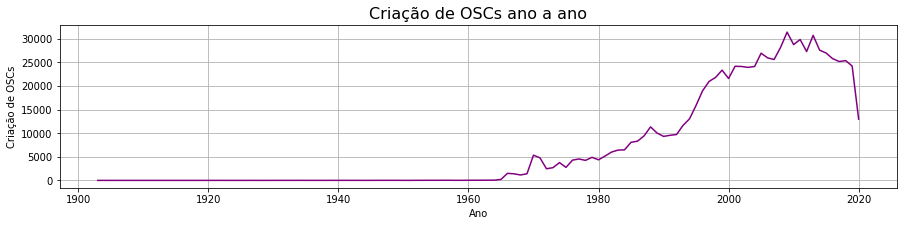

In [22]:
f, ax = plt.subplots(figsize=(15,3))
x = b["Ano"]
ax.plot(x,b['osc_criada'], color='purple')

ax.set_xlabel('Ano')
ax.set_ylabel('Criação de OSCs')
ax.set_title('Criação de OSCs ano a ano', fontsize = 16)
ax.grid(True)

plt.show()

O gráfico acima mostra o aumento no numéro de OSCs criadas após os anos 1960 e a queda significativa que vem sendo registrada nos últimos anos, provavelmente decorrente da falta de dados consolidados pros últimos anos.

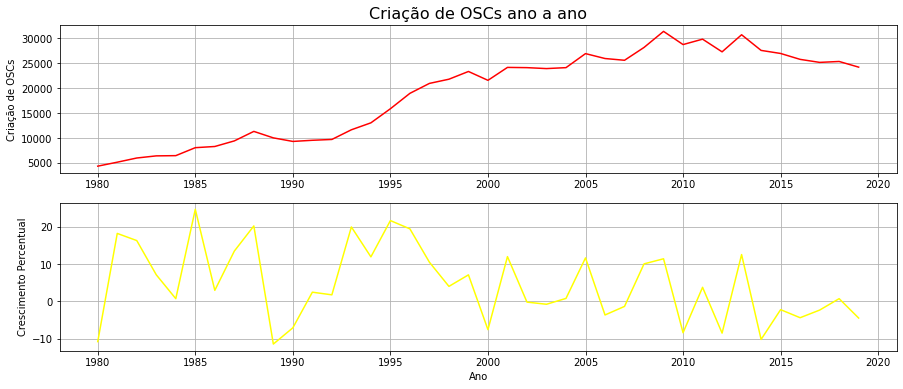

In [23]:
f, ax = plt.subplots(2, figsize=(15,6))
x = c["Ano"]
ax[0].plot(x,c['osc_criada'], color='red')
ax[1].plot(x,c['crescimento_yoy'], color='yellow')

#ax[0].set_xlabel('Ano')
ax[0].set_ylabel('Criação de OSCs')
ax[0].set_title('Criação de OSCs ano a ano', fontsize = 16)

ax[0].grid(True)
ax[1].grid(True)

ax[1].set_xlabel('Ano')
ax[1].set_ylabel('Crescimento Percentual')

plt.show()

#### 3. Número de OSCs por atividade econômica


In [24]:
e = df2.groupby('tx_nome_classe_atividade_economica')['id_osc'].count().reset_index()
e.rename(columns={'id_osc': 'osc_criada'}, inplace=True)
e.sort_values(by = 'osc_criada' , ascending = False, inplace = True)

In [25]:
e = e.head(5)

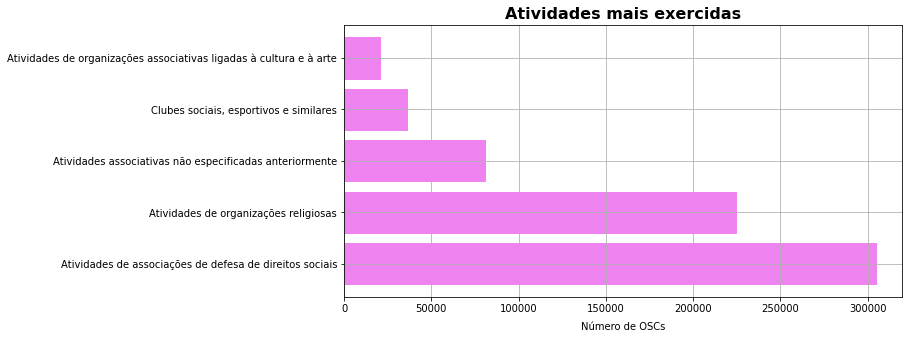

In [26]:
fig, ax = plt.subplots(figsize=(10,5))

ax.barh(e['tx_nome_classe_atividade_economica'],e['osc_criada'], Color='violet')

plt.title("Atividades mais exercidas", 
          fontdict={'family': 'cursive', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})
plt.xlabel("Número de OSCs", 
           family='cursive', 
           color='black', 
           weight='normal', 
           size = 10,
           labelpad = 8)
plt.grid(True)


Percebemos que a maior concentração de atividades exercidas são quanto a atividades de associações de defesa de direitos sociais e atividades de organizações religiosas. Mostrando certa complementariedade em relação a atividades puramente exercidas pelo Estado.

### **Análise dos recursos**

#### 1. OSCs que mais receberam recursos

In [27]:
df_osc_recurso = df1.groupby(by = 'id_osc')['nr_valor_recursos_osc'].sum().reset_index(name='nr_valor_recursos_osc')
df_osc_recurso.sort_values(by = 'nr_valor_recursos_osc', ascending = False, inplace = True)

In [28]:
df_osc = df1[['id_osc', 'tx_razao_social_osc']]
df_osc = df_osc.drop_duplicates(subset='id_osc', keep='first') #procurando pelo nome do doador

In [29]:
df_recursos = pd.merge(df_osc_recurso,df_osc, how ='left', on = 'id_osc')
df_recursos = df_recursos.sort_values(by = 'nr_valor_recursos_osc', ascending = False)
df_recursos

id_osc  nr_valor_recursos_osc  \
0       609177           7.791367e+09   
1      1078471           7.479585e+09   
2       559259           3.433786e+09   
3       565048           2.959399e+09   
4       762781           2.772985e+09   
...        ...                    ...   
21520   435167           0.000000e+00   
21521   478801           0.000000e+00   
23224  1004489          -1.991463e-15   
23225   703709          -9.103829e-15   
23226   528113          -1.421085e-14   

                                     tx_razao_social_osc  
0                                      FUNDACAO BUTANTAN  
1                       ASSOCIACAO DAS PIONEIRAS SOCIAIS  
2      FUNDACAO REDE FERROVIARIA DE SEGURIDADE SOCIAL...  
3      FIOTEC - FUNDACAO PARA O DESENVOLVIMENTO CIENT...  
4                                MISSAO EVANGELICA CAIUA  
...                                                  ...  
21520        ASSOCIACAO COMUNITARIA DE RIACHO DAS PEDRAS  
21521  ASSOCIACAO SUL BRASILEIRA DE EDUCACAO E ASSIST...  
23224                ASSOCIACAO REMIGENSE DE APICULTORES  
23225                       SOCIEDADE DIVINA PROVIDENCIA  
23226  ASSOCIACAO DE PEQ PROD RURAIS E DE MULHERES DE...  

[23227 rows x 3 columns]

In [30]:
df_recursos_top10 = df_recursos.head(10)

Text(0.5, 0, 'Valor recursos recebidos')

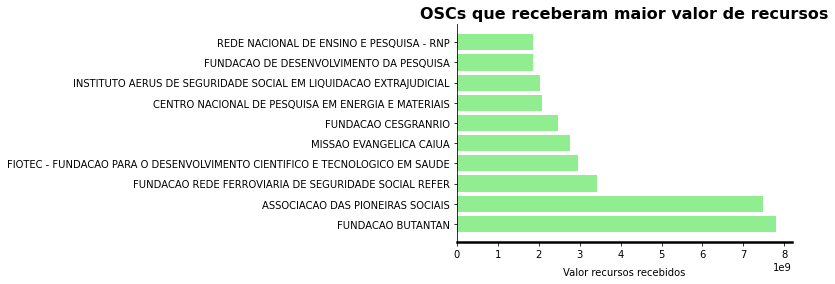

In [31]:
fig, ax = plt.subplots()
p1 = ax.barh(df_recursos_top10['tx_razao_social_osc'],df_recursos_top10['nr_valor_recursos_osc'], color='lightgreen')
plt.title("OSCs que receberam maior valor de recursos", 
          fontdict={'family': 'cursive', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 16})


ax.spines['bottom'].set_linewidth(2.5)

for axis in ['top', 'right']:
   ax.spines[axis].set_color(None)

plt.xlabel("Valor recursos recebidos", 
           family='cursive', 
           color='black', 
           weight='normal', 
           size = 10,
           labelpad = 8)

Podemos ver com o auxílio do gráfico acima as OSCs que receberam mais recursos, o maior beneficiário foi o Instituto Butantan.

#### 2. Fontes que mais doaram recursos

In [32]:
df_doadores = df1[['tx_nome_fonte_recursos_osc','Ano','nr_valor_recursos_osc']].groupby(['Ano','tx_nome_fonte_recursos_osc'])['nr_valor_recursos_osc'].sum().reset_index()
df_doadores_max = df_doadores.groupby('Ano')['nr_valor_recursos_osc'].max()

In [33]:
df_maiores_doadores = pd.merge(df_doadores_max, df_doadores, on=['nr_valor_recursos_osc'], how='left')

In [34]:
df_doadores2 = df_doadores[df_doadores['nr_valor_recursos_osc']>100000000]

In [35]:
df_doadores2 = df_doadores2[df_doadores2['Ano']<2020]

In [36]:
fig = px.bar(df_maiores_doadores, x="nr_valor_recursos_osc", y="tx_nome_fonte_recursos_osc", color="Ano", barmode="group")
fig.show()

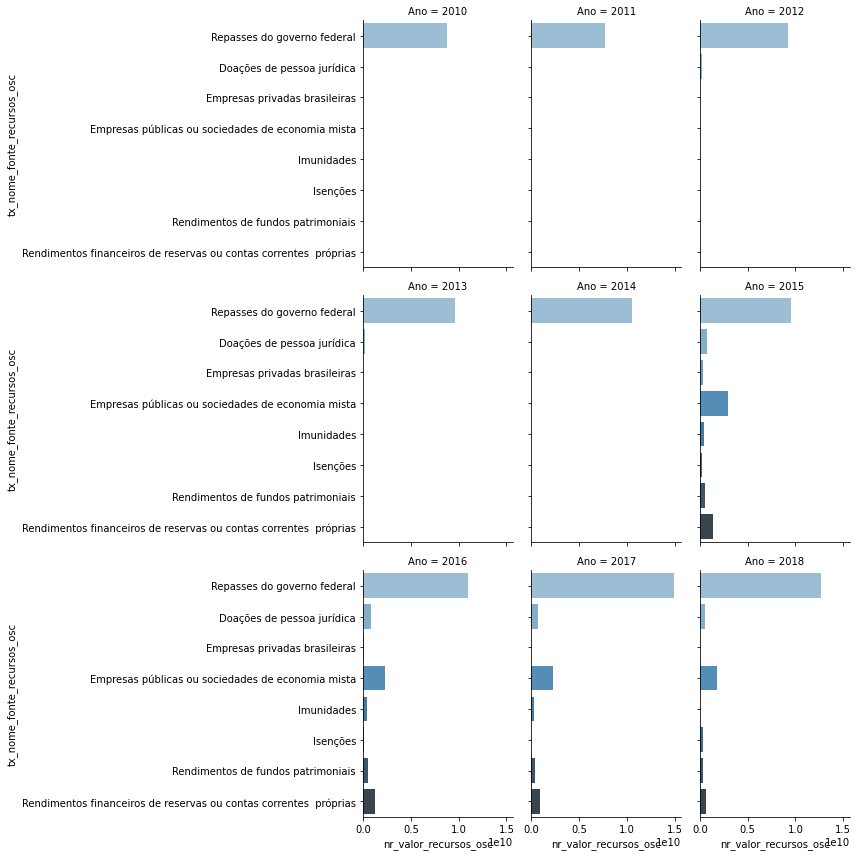

In [37]:
plot2 = sns.catplot(data=df_doadores2, y="tx_nome_fonte_recursos_osc", x="nr_valor_recursos_osc",
                 col = "Ano" ,col_wrap=3 ,height=4,kind="bar", palette="Blues_d")

Percebe-se a relevância dos repasses do governo federal para a ampliação e manutenção das OSCs.

#### 3. Total de recursos por ano

In [38]:
sum_recursos = df1.groupby(by = 'Ano')['nr_valor_recursos_osc'].sum().reset_index()
count_recursos = df1.groupby(by = 'Ano')['nr_valor_recursos_osc'].count().reset_index()

In [39]:
df_recursos_ano = pd.merge(sum_recursos,count_recursos,right_index=True, left_index=True)

In [40]:
df_recursos_ano.rename(columns = {'nr_valor_recursos_osc_x':'valor_recursos', 'nr_valor_recursos_osc_y':'num_recursos', 'Ano_x': 'Ano'}, inplace = True)

In [41]:
df_recursos_ano = df_recursos_ano[df_recursos_ano['Ano']<2018]

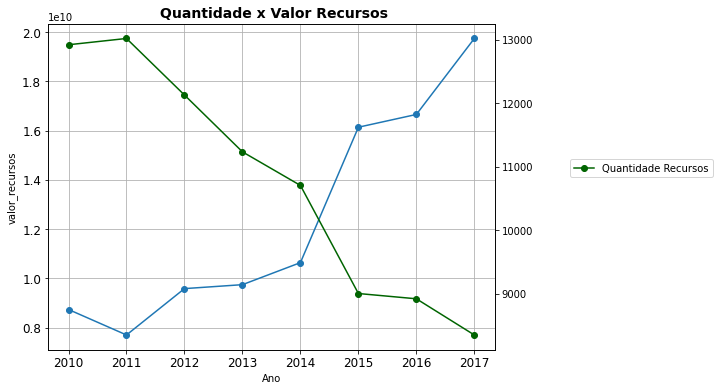

In [42]:
fig,ax = plt.subplots(figsize=(8,6))

plt.title(" Quantidade x Valor Recursos" , 
          fontdict={'family': 'cursive', 
                    'color' : 'black',
                    'weight': 'bold',
                    'size': 14})

ax.set_xlabel("Ano")
ax.set_ylabel("valor_recursos")
ax.tick_params(labelsize=12)
#ax2.tick_params(labelsize=12)

ax.grid(True)

ax2=ax.twinx()
ax2.plot(df_recursos_ano.Ano, df_recursos_ano["num_recursos"],color="darkgreen",marker="o")
ax.plot(df_recursos_ano.Ano, df_recursos_ano["valor_recursos"], marker="o")

plt.legend(["Quantidade Recursos", "Valor Recursos"], bbox_to_anchor = (1.5, 0.6))

Transformando a coluna Ano em um tipo de data.

In [43]:
df_recursos_ano['Ano'] = pd.PeriodIndex(df_recursos_ano['Ano'], freq='A')

In [44]:
fig = px.scatter(df_recursos_ano, x="valor_recursos", y="num_recursos",color = 'Ano', width=700, height=400)
fig.show()

O gráfico acima mostra a relação entre o valor dos recursos e a quantidade de OSCs que receberam entre os anos de 2010-2017

#### 4. UFs e municípios que mais receberam recursos

In [45]:
df_mun_osc = df2[['id_osc', 'edmu_nm_municipio']]
df_mun_osc = df_mun_osc.drop_duplicates(subset='id_osc', keep='first')

In [46]:
df_recursos_mun = pd.merge(df_osc_recurso,df_mun_osc, how ='left', on = 'id_osc')
df_recursos_mun = df_recursos_mun[['nr_valor_recursos_osc','edmu_nm_municipio']]

In [47]:
df_recursos_mun = df_recursos_mun.groupby(by='edmu_nm_municipio').sum().sort_values(by = 'nr_valor_recursos_osc', ascending = False).reset_index()

In [48]:
df_uf_osc = df2[['id_osc', 'eduf_sg_uf']]
df_uf_osc = df_uf_osc.drop_duplicates(subset='id_osc', keep='first')

In [49]:
df_recursos_uf = pd.merge(df_osc_recurso,df_uf_osc, how ='left', on = 'id_osc')
df_recursos_uf = df_recursos_uf[['nr_valor_recursos_osc','eduf_sg_uf']]

In [50]:
df_recursos_uf = df_recursos_uf.groupby(by='eduf_sg_uf').sum().sort_values(by = 'nr_valor_recursos_osc', ascending = False).reset_index()

In [51]:
def univariate_bar_uf(df_recursos_uf,color,place):
    fig = go.Figure()

    fig.add_trace(
        go.Bar(x=df_recursos_uf['eduf_sg_uf'][:5],
               y=df_recursos_uf['nr_valor_recursos_osc'][:5],
               name= place + " 5",
              marker={'color': df_recursos_uf['nr_valor_recursos_osc'][:5],'colorscale': color}))
    fig.add_trace(
        go.Bar(x=df_recursos_uf['eduf_sg_uf'][:10],
               y=df_recursos_uf['nr_valor_recursos_osc'][:10],
               name=place + " 10",
              marker={'color': df_recursos_uf['nr_valor_recursos_osc'][:10],'colorscale': color}))
    fig.add_trace(
        go.Bar(x=df_recursos_uf['eduf_sg_uf'][:15],
               y=df_recursos_uf['nr_valor_recursos_osc'][:15],
               name= place + " 15",
              marker={'color': df_recursos_uf['nr_valor_recursos_osc'][:15],'colorscale': color}))
     
    fig.update_layout(
        updatemenus=[
            dict(type="buttons", direction="left", active=0, x=0.8, y=1.6,
                buttons=list([
                    dict(label= place + " 5",
                         method="restyle",
                         args=[{"visible": [True, False,False, False, False]},
                               {"title": "Top 5" }]),
                    dict(label= place + " 10",
                         method="restyle",
                         args=[{"visible": [False,True, False, False, False]},
                               {"title": "Top 10"}]),
                    dict(label=place + " 15",
                         method="restyle",
                         args=[{"visible": [False,False, True, False, False]},
                               {"title": "Top 15"}]),
                              ])
                )
        ])
    fig.update_layout(
    title_text="UFs com maior número de doações (R$)",
    xaxis_domain=[0.05, 1.0])
    
    
    fig.update_traces(showlegend=False)

    fig.show()

In [52]:
def univariate_bar_mn(df_recursos,color,place):
    fig = go.Figure()

    fig.add_trace(
        go.Bar(x=df_recursos['edmu_nm_municipio'][:5],
               y=df_recursos['nr_valor_recursos_osc'][:5],
               name= place + " 5",
              marker={'color': df_recursos['nr_valor_recursos_osc'][:5],'colorscale': color}))
    fig.add_trace(
        go.Bar(x=df_recursos['edmu_nm_municipio'][:10],
               y=df_recursos['nr_valor_recursos_osc'][:10],
               name=place + " 10",
              marker={'color': df_recursos['nr_valor_recursos_osc'][:10],'colorscale': color}))
    fig.add_trace(
        go.Bar(x=df_recursos['edmu_nm_municipio'][:15],
               y=df_recursos['nr_valor_recursos_osc'][:15],
               name= place + " 15",
              marker={'color': df_recursos['nr_valor_recursos_osc'][:15],'colorscale': color}))
     
    fig.update_layout(
        updatemenus=[
            dict(type="buttons", direction="left", active=0, x=0.8, y=1.6,
                buttons=list([
                    dict(label= place + " 5",
                         method="restyle",
                         args=[{"visible": [True, False,False, False, False]},
                               {"title": "Top 5" }]),
                    dict(label= place + " 10",
                         method="restyle",
                         args=[{"visible": [False,True, False, False, False]},
                               {"title": "Top 10"}]),
                    dict(label=place + " 15",
                         method="restyle",
                         args=[{"visible": [False,False, True, False, False]},
                               {"title": "Top 15"}]),
                              ])
                )
        ])
    fig.update_layout(
    title_text="UFs com maior número de doações (R$)",
    xaxis_domain=[0.05, 1.0])
    
    
    fig.update_traces(showlegend=False)

    fig.show()

In [53]:
univariate_bar_mn(df_recursos_mun , 'Greens', 'Top')

Percebemos a forte concentração de recursos recebidos pelos municípios do Rio de Janeiro, São Paulo e Brasília, municípios com um contingente populacional muito grande e com consequente demanda alta por serviços. Desse modo, não é de se surpreender que os 3 municípios estejam no topo da lista.

In [54]:
univariate_bar_uf(df_recursos_uf , 'Greens', 'Top')

Novamente é possível vizualizar a maior concentração de recursos nos Estados de SP, RJ, MG e no DF.

#### 5. Valor de recursos por ano de doação e UF

In [55]:
teste3 = df1.groupby(['id_osc','Ano'])['nr_valor_recursos_osc'].sum().reset_index(name='nr_valor_recursos_osc')
teste3.sort_values(by = 'nr_valor_recursos_osc', ascending = False, inplace = True)

In [56]:
teste3 = pd.merge(teste3, df2[['id_osc','eduf_sg_uf']], how = 'left', on = 'id_osc')

In [57]:
teste3 = teste3[teste3['nr_valor_recursos_osc']>0]
teste3 = teste3[teste3['Ano']<2019]

In [82]:
fig = px.bar(teste3, x="Ano", y="nr_valor_recursos_osc", color="eduf_sg_uf", width = 1000)
fig.show()

No gráfico acima é possível ver a relação entre o valor de recursos recebidos por ano em relaçao a distribuição entre as UFs

#### 6. Valor de recursos por ano e atividades econômicas

In [59]:
teste4 = df1.groupby(['id_osc','Ano'])['nr_valor_recursos_osc'].sum().reset_index(name='nr_valor_recursos_osc')

In [60]:
teste5 = pd.merge(teste4, df2[['id_osc','eduf_sg_uf','tx_nome_classe_atividade_economica','tx_razao_social_osc']], how = 'left', on = 'id_osc')

In [61]:
teste4.sort_values(['Ano','nr_valor_recursos_osc'], ascending = False, inplace = True)

In [62]:
teste4.groupby(['Ano'])['nr_valor_recursos_osc'].max().reset_index()

Ano  nr_valor_recursos_osc
0   2010           5.605046e+08
1   2011           6.762085e+08
2   2012           7.163258e+08
3   2013           7.454500e+08
4   2014           7.697495e+08
5   2015           8.968823e+08
6   2016           1.474595e+09
7   2017           3.409063e+09
8   2018           1.939092e+09
9   2019           1.142426e+08
10  2020           1.280000e+09
11  2021           1.042667e+08
12  2022           1.600000e+06

In [80]:
df = px.data.gapminder()
fig = px.scatter(teste5, x="Ano", y="nr_valor_recursos_osc",  animation_group="tx_nome_classe_atividade_economica",
            color="tx_nome_classe_atividade_economica", hover_name="eduf_sg_uf",
           log_x=True, size_max=50,width=1500)
fig.show()

O gráfico acima mostra a relação do valor de recursos por ano em cada classe de atividade econômica.

#### 7. Relação entre valor recebido por ano e quantidade de OSCs que receberam

In [64]:
df1['Ano'] = df1['dt_ano_recursos_osc'].dt.year
df2['Ano'] = df2['dt_fundacao_osc'].dt.year

In [65]:
grouped1 = df1.groupby(by = 'Ano')
soma_valor = grouped1['nr_valor_recursos_osc'].sum()
num_valor = grouped1['nr_valor_recursos_osc'].count()

In [66]:
df1_a = pd.merge(soma_valor,num_valor,right_index=True, left_index=True)
df1_a = df1_a.reset_index()
df1_a.rename(columns = {'nr_valor_recursos_osc_x':'valor_rec', 'nr_valor_recursos_osc_y':'num_rec'}, inplace = True)

df1_a

Ano     valor_rec  num_rec
0   2010  8.740400e+09    12923
1   2011  7.707256e+09    13022
2   2012  9.588157e+09    12131
3   2013  9.748356e+09    11236
4   2014  1.064267e+10    10707
5   2015  1.613641e+10     9004
6   2016  1.665469e+10     8921
7   2017  1.973754e+10     8351
8   2018  1.648707e+10     8888
9   2019  1.304707e+08       68
10  2020  1.540707e+09      131
11  2021  2.331012e+08       22
12  2022  1.600000e+06        5

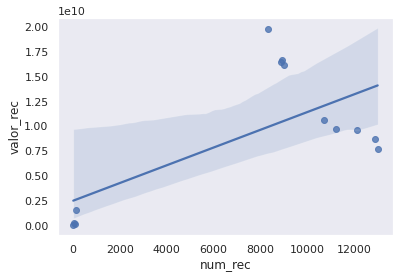

In [67]:
sns.set_theme(style="dark")
sns.regplot(x="num_rec", y="valor_rec", data=df1_a)

#### 8. Relação entre o valor recebido e as UFs

In [68]:
df2_a = df2[['id_osc', 'eduf_sg_uf']]
df2_a = df2_a.drop_duplicates(subset='id_osc', keep='first')
df2_a

id_osc eduf_sg_uf
0        394905         RO
1        394906         RO
2        394907         RO
3        394908         RO
4        394909         RO
...         ...        ...
815670  1336517         RS
815671  1336518         SP
815672  1336519         MG
815673  1336520         MG
815674  1336521         MA

[815675 rows x 2 columns]

In [69]:
grouped2 = df1.groupby(by = 'id_osc')

In [70]:
grouped2 = grouped2['nr_valor_recursos_osc'].sum()

In [71]:
df1_b = grouped2.rename_axis('id_osc').reset_index(name='nr_valor_recursos_osc')
df1_b

id_osc  nr_valor_recursos_osc
0       394907               93180.00
1       394912               52352.00
2       394913               46364.00
3       394926                3268.00
4       394933              948801.10
...        ...                    ...
23222  1287814              344913.00
23223  1288002              143915.11
23224  1288026                 170.00
23225  1288048                   0.00
23226  1288108              175375.00

[23227 rows x 2 columns]

In [72]:
df1_b.sort_values(by = 'nr_valor_recursos_osc', ascending = False)

id_osc  nr_valor_recursos_osc
12133   609177           7.791367e+09
21162  1078471           7.479585e+09
9873    559259           3.433786e+09
10397   565048           2.959399e+09
16206   762781           2.772985e+09
...        ...                    ...
17637   788956           0.000000e+00
3008    433719           0.000000e+00
20388  1004489          -1.991463e-15
14585   703709          -9.103829e-15
8527    528113          -1.421085e-14

[23227 rows x 2 columns]

In [73]:
df_auxiliar = pd.merge(df1_b,df2_a[['id_osc', 'eduf_sg_uf']], how ='left', on = 'id_osc')

df_auxiliar

id_osc  nr_valor_recursos_osc eduf_sg_uf
0       394907               93180.00         RO
1       394912               52352.00         RO
2       394913               46364.00         RO
3       394926                3268.00         RO
4       394933              948801.10         RO
...        ...                    ...        ...
23222  1287814              344913.00         RS
23223  1288002              143915.11         RS
23224  1288026                 170.00         RS
23225  1288048                   0.00         RS
23226  1288108              175375.00         DF

[23227 rows x 3 columns]

In [74]:
df_auxiliar = df_auxiliar.sort_values(by = 'nr_valor_recursos_osc', ascending = False)
df_auxiliar

id_osc  nr_valor_recursos_osc eduf_sg_uf
12133   609177           7.791367e+09         SP
21162  1078471           7.479585e+09         DF
9873    559259           3.433786e+09         RJ
10397   565048           2.959399e+09         RJ
16206   762781           2.772985e+09         MS
...        ...                    ...        ...
17637   788956           0.000000e+00         SP
3008    433719           0.000000e+00         CE
20388  1004489          -1.991463e-15         PB
14585   703709          -9.103829e-15         SC
8527    528113          -1.421085e-14         MG

[23227 rows x 3 columns]

In [75]:
df_auxiliar_2 = df_auxiliar.groupby(by='eduf_sg_uf')
df_auxiliar_2

In [76]:
df_auxiliar_2.head()

id_osc  nr_valor_recursos_osc eduf_sg_uf
12133   609177           7.791367e+09         SP
21162  1078471           7.479585e+09         DF
9873    559259           3.433786e+09         RJ
10397   565048           2.959399e+09         RJ
16206   762781           2.772985e+09         MS
...        ...                    ...        ...
20399  1005334           3.181949e+06         AP
456     402648           3.101602e+06         RR
20627  1016898           2.295000e+06         RR
18985   901237           1.770000e+06         RR
477     402953           1.689619e+06         RR

[135 rows x 3 columns]

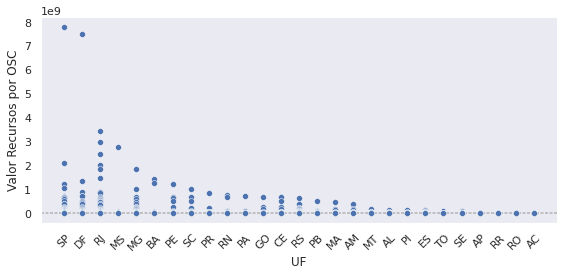

In [77]:
plot = sns.relplot(data=df_auxiliar, x="eduf_sg_uf", y="nr_valor_recursos_osc",height=4, aspect=2)
plt.xticks(rotation=45)
(plot.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("UF", "Valor Recursos por OSC")
  .tight_layout(w_pad=0))
plt.show()

O gráfico acima é possível ver a distribuição dos recursos por OSCs em cada UF